#Important all necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm
from torchaudio.datasets import SPEECHCOMMANDS
import os

#Checking availability of GPU/CPU

In [ ]:
#Checking if the GPU is available or not, if runtime is set to GPU, our code is
#running on GPU else on CPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#Downloading Dataset

In [ ]:
class Download_and_split_SC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "test":
            self._walker = load_list("testing_list.txt")
        elif subset == "train":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

##Splitting the dataset into train and test sets

In [ ]:
train_dataset = Download_and_split_SC("train")
test_dataset = Download_and_split_SC("test")

In [ ]:
len(train_dataset)

84843

In [ ]:
len(test_dataset)

11005

#Visualization of the dataset

##Observing the properties of the dataset

In [ ]:
waveform, sample_rate, label, speaker_id, utterance_number = train_dataset[0]

In [ ]:
waveform

tensor([[-0.0658, -0.0709, -0.0753,  ..., -0.0700, -0.0731, -0.0704]])

In [ ]:
sample_rate

16000

In [ ]:
label

'backward'

In [ ]:
speaker_id

'0165e0e8'

In [ ]:
utterance_number

0

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


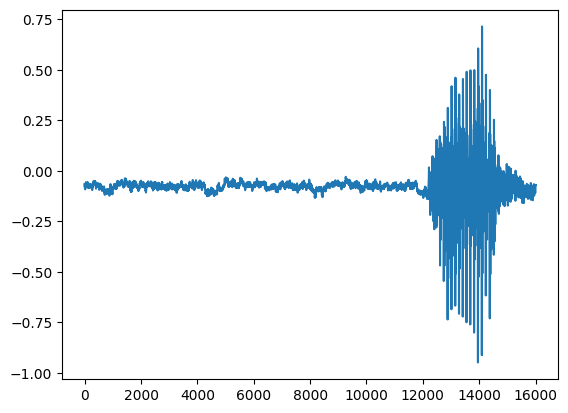

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [ ]:
waveform1, sample_rate1, label1, speaker_id1, utterance_number1 = train_dataset[1800]

In [ ]:
waveform1

tensor([[-0.0032, -0.0037, -0.0035,  ..., -0.0052, -0.0050, -0.0053]])

In [ ]:
sample_rate1

16000

In [ ]:
label1

'bed'

In [ ]:
speaker_id1

'4b25f620'

In [ ]:
utterance_number1

1

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


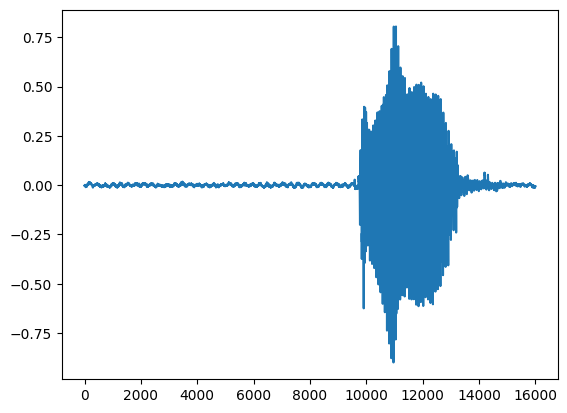

In [ ]:
print("Shape of waveform: {}".format(waveform1.size()))
print("Sample rate of waveform: {}".format(sample_rate1))

plt.plot(waveform1.t().numpy());

##Visualizing the labels of the dataset

In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in train_dataset)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

##Visulaizing Audio of the dataset

In [ ]:
waveform_first, *_ = train_dataset[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)


In [ ]:
waveform_ninth, *_ = train_dataset[8]
ipd.Audio(waveform_ninth.numpy(), rate=sample_rate)

In [ ]:
waveform_5989, *_ = train_dataset[5988]
ipd.Audio(waveform_5989.numpy(), rate=sample_rate)

In [ ]:
waveform_last, *_ = train_dataset[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

#Data Agumentation

In [ ]:
#Data agumentation is important because it can prevent our model from overfitting

In [ ]:
#here we are doing the resampling of the audio as a part of data agumentation to
#reduce the computational cost of processing the signal, as it can help to create
#additional data points by changing the sampling rate of the audio signals.
#This can increase the size of the dataset and improve the performance of the model

In [ ]:
new_sample_rate = 1
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
# randomly add noise
# transform = transforms.RandomApply([torch.nn.Sequential(
#         torchaudio.transforms.AdditiveNoise(p=0.5),
#     )], p=0.5),
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

#Defing Hyperparameters

In [ ]:
batch_size = 256
epoch = 30
#optimizer__ = Adam or Stocastic gradient
#loss = cross entropy or

#Defining the train and test loader

##Defining certain functions

In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))

def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn,num_workers=num_workers,pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False,drop_last=False,collate_fn=collate_fn,num_workers=num_workers,pin_memory=pin_memory)

#Implementing the model

In [ ]:
#we have built the RNN model

In [ ]:
import torch.nn as nn

class M5_RNN(nn.Module):
    def __init__(self, n_input=1, n_output=35, n_hidden=64, n_layers=2):
        super().__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.rnn = nn.RNN(n_input, n_hidden, n_layers, batch_first=True)
        self.fc = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.n_layers, batch_size, self.n_hidden).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return F.log_softmax(out, dim=1)

model_rnn = M5_RNN(n_input=transformed.shape[0], n_output=len(labels))
model_rnn.to(device)
print(model_rnn)

M5_RNN(
  (rnn): RNN(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=35, bias=True)
)


#Defining the optimizer and loss function

In [ ]:
optimizer = optim.Adam(model_rnn.parameters(), lr=0.001, weight_decay=0.0001)
# optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [ ]:
# criterion = nn.functional.nll_loss()
# criterion = nn.CrossEntropyLoss()

#Training the model

In [ ]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = nn.functional.nll_loss(output.squeeze(), target)
        # loss = criterion(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        # pbar.update(pbar_update)
        # record loss
        # losses.append(loss.item())

In [ ]:
#for batch-size = 256

In [ ]:
train(model_rnn,30,20)

Train Epoch: 30 [0/84843 (0%)]	Loss: 3.559620
Train Epoch: 30 [5120/84843 (6%)]	Loss: 3.523321
Train Epoch: 30 [10240/84843 (12%)]	Loss: 3.510059
Train Epoch: 30 [15360/84843 (18%)]	Loss: 3.485088
Train Epoch: 30 [20480/84843 (24%)]	Loss: 3.559773
Train Epoch: 30 [25600/84843 (30%)]	Loss: 3.495030
Train Epoch: 30 [30720/84843 (36%)]	Loss: 3.479050
Train Epoch: 30 [35840/84843 (42%)]	Loss: 3.520904
Train Epoch: 30 [40960/84843 (48%)]	Loss: 3.521973
Train Epoch: 30 [46080/84843 (54%)]	Loss: 3.503622
Train Epoch: 30 [51200/84843 (60%)]	Loss: 3.491368
Train Epoch: 30 [56320/84843 (66%)]	Loss: 3.459888
Train Epoch: 30 [61440/84843 (72%)]	Loss: 3.473242
Train Epoch: 30 [66560/84843 (78%)]	Loss: 3.500287
Train Epoch: 30 [71680/84843 (84%)]	Loss: 3.482856
Train Epoch: 30 [76800/84843 (90%)]	Loss: 3.511638
Train Epoch: 30 [81920/84843 (96%)]	Loss: 3.519269


In [ ]:
#we have built the  model

In [ ]:
train(model_rnn,50,20)

Train Epoch: 50 [0/84843 (0%)]	Loss: 3.499972
Train Epoch: 50 [5120/84843 (6%)]	Loss: 3.493759
Train Epoch: 50 [10240/84843 (12%)]	Loss: 3.509562
Train Epoch: 50 [15360/84843 (18%)]	Loss: 3.461777
Train Epoch: 50 [20480/84843 (24%)]	Loss: 3.518504
Train Epoch: 50 [25600/84843 (30%)]	Loss: 3.504491
Train Epoch: 50 [30720/84843 (36%)]	Loss: 3.511660
Train Epoch: 50 [35840/84843 (42%)]	Loss: 3.485420
Train Epoch: 50 [40960/84843 (48%)]	Loss: 3.532993
Train Epoch: 50 [46080/84843 (54%)]	Loss: 3.514882
Train Epoch: 50 [51200/84843 (60%)]	Loss: 3.490666
Train Epoch: 50 [56320/84843 (66%)]	Loss: 3.483118
Train Epoch: 50 [61440/84843 (72%)]	Loss: 3.471824
Train Epoch: 50 [66560/84843 (78%)]	Loss: 3.523673
Train Epoch: 50 [71680/84843 (84%)]	Loss: 3.491619
Train Epoch: 50 [76800/84843 (90%)]	Loss: 3.511342
Train Epoch: 50 [81920/84843 (96%)]	Loss: 3.499390


In [ ]:
train(model_rnn,120,20)

Train Epoch: 120 [0/84843 (0%)]	Loss: 3.475311
Train Epoch: 120 [5120/84843 (6%)]	Loss: 3.519197
Train Epoch: 120 [10240/84843 (12%)]	Loss: 3.513041
Train Epoch: 120 [15360/84843 (18%)]	Loss: 3.506081
Train Epoch: 120 [20480/84843 (24%)]	Loss: 3.513651
Train Epoch: 120 [25600/84843 (30%)]	Loss: 3.471093
Train Epoch: 120 [30720/84843 (36%)]	Loss: 3.528052
Train Epoch: 120 [35840/84843 (42%)]	Loss: 3.470295
Train Epoch: 120 [40960/84843 (48%)]	Loss: 3.468193
Train Epoch: 120 [46080/84843 (54%)]	Loss: 3.525106
Train Epoch: 120 [51200/84843 (60%)]	Loss: 3.501904
Train Epoch: 120 [56320/84843 (66%)]	Loss: 3.528369
Train Epoch: 120 [61440/84843 (72%)]	Loss: 3.488992
Train Epoch: 120 [66560/84843 (78%)]	Loss: 3.491758
Train Epoch: 120 [71680/84843 (84%)]	Loss: 3.480211
Train Epoch: 120 [76800/84843 (90%)]	Loss: 3.502780
Train Epoch: 120 [81920/84843 (96%)]	Loss: 3.496535


In [ ]:
#for batch-size = 120

In [ ]:
train(model_rnn,30,20)

Train Epoch: 30 [0/84843 (0%)]	Loss: 3.494680
Train Epoch: 30 [5120/84843 (6%)]	Loss: 3.511751
Train Epoch: 30 [10240/84843 (12%)]	Loss: 3.508148
Train Epoch: 30 [15360/84843 (18%)]	Loss: 3.498216
Train Epoch: 30 [20480/84843 (24%)]	Loss: 3.531823
Train Epoch: 30 [25600/84843 (30%)]	Loss: 3.488989
Train Epoch: 30 [30720/84843 (36%)]	Loss: 3.502468
Train Epoch: 30 [35840/84843 (42%)]	Loss: 3.521461
Train Epoch: 30 [40960/84843 (48%)]	Loss: 3.502986
Train Epoch: 30 [46080/84843 (54%)]	Loss: 3.459469
Train Epoch: 30 [51200/84843 (60%)]	Loss: 3.495537
Train Epoch: 30 [56320/84843 (66%)]	Loss: 3.512074
Train Epoch: 30 [61440/84843 (72%)]	Loss: 3.491352
Train Epoch: 30 [66560/84843 (78%)]	Loss: 3.502696
Train Epoch: 30 [71680/84843 (84%)]	Loss: 3.525645
Train Epoch: 30 [76800/84843 (90%)]	Loss: 3.467765
Train Epoch: 30 [81920/84843 (96%)]	Loss: 3.517430


In [ ]:
#for batch-size = 32

In [ ]:
train(model_rnn,30,20)

Train Epoch: 30 [0/84843 (0%)]	Loss: 3.475362
Train Epoch: 30 [5120/84843 (6%)]	Loss: 3.503821
Train Epoch: 30 [10240/84843 (12%)]	Loss: 3.504966
Train Epoch: 30 [15360/84843 (18%)]	Loss: 3.552123
Train Epoch: 30 [20480/84843 (24%)]	Loss: 3.490181
Train Epoch: 30 [25600/84843 (30%)]	Loss: 3.506970
Train Epoch: 30 [30720/84843 (36%)]	Loss: 3.500985
Train Epoch: 30 [35840/84843 (42%)]	Loss: 3.493864
Train Epoch: 30 [40960/84843 (48%)]	Loss: 3.481001
Train Epoch: 30 [46080/84843 (54%)]	Loss: 3.486143
Train Epoch: 30 [51200/84843 (60%)]	Loss: 3.476663
Train Epoch: 30 [56320/84843 (66%)]	Loss: 3.489318
Train Epoch: 30 [61440/84843 (72%)]	Loss: 3.517868
Train Epoch: 30 [66560/84843 (78%)]	Loss: 3.514377
Train Epoch: 30 [71680/84843 (84%)]	Loss: 3.516007
Train Epoch: 30 [76800/84843 (90%)]	Loss: 3.508572
Train Epoch: 30 [81920/84843 (96%)]	Loss: 3.512790


In [ ]:
#for optimizer = stocastic gradient, batch-size = 32

In [ ]:
train(model_rnn,30,20)

Train Epoch: 30 [0/84843 (0%)]	Loss: 3.481726
Train Epoch: 30 [5120/84843 (6%)]	Loss: 3.494487
Train Epoch: 30 [10240/84843 (12%)]	Loss: 3.489565
Train Epoch: 30 [15360/84843 (18%)]	Loss: 3.496015
Train Epoch: 30 [20480/84843 (24%)]	Loss: 3.450080
Train Epoch: 30 [25600/84843 (30%)]	Loss: 3.502276
Train Epoch: 30 [30720/84843 (36%)]	Loss: 3.504688
Train Epoch: 30 [35840/84843 (42%)]	Loss: 3.469882
Train Epoch: 30 [40960/84843 (48%)]	Loss: 3.523783
Train Epoch: 30 [46080/84843 (54%)]	Loss: 3.469990
Train Epoch: 30 [51200/84843 (60%)]	Loss: 3.476875
Train Epoch: 30 [56320/84843 (66%)]	Loss: 3.493445
Train Epoch: 30 [61440/84843 (72%)]	Loss: 3.484253
Train Epoch: 30 [66560/84843 (78%)]	Loss: 3.501410
Train Epoch: 30 [71680/84843 (84%)]	Loss: 3.526378
Train Epoch: 30 [76800/84843 (90%)]	Loss: 3.536133
Train Epoch: 30 [81920/84843 (96%)]	Loss: 3.495779


#Testing the model

In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

In [ ]:
def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        # pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [ ]:
#for batch-size = 256, optimizer = Adam,

In [ ]:
test(model_rnn,30)


Test Epoch: 30	Accuracy: 406/11005 (4%)



In [ ]:
test(model_rnn,50)


Test Epoch: 50	Accuracy: 406/11005 (4%)



In [ ]:
test(model_rnn,120)


Test Epoch: 120	Accuracy: 406/11005 (4%)



In [ ]:
#for batch-size = 120

In [ ]:
test(model_rnn,30)


Test Epoch: 30	Accuracy: 406/11005 (4%)



In [ ]:
#for batch-size = 32

In [ ]:
test(model_rnn,30)


Test Epoch: 30	Accuracy: 406/11005 (4%)



In [ ]:
#for optimizer = stocastic gradient, batch-size = 32

In [ ]:
test(model_rnn,30)


Test Epoch: 30	Accuracy: 406/11005 (4%)



In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class M5Transformer(nn.Module):
    def __init__(self, n_input=1, n_output=35, n_channel=32, d_model=128, nhead=4, num_layers=3):
        super().__init__()
        self.pos_encoder = nn.Sequential(
            nn.Linear(n_input, d_model),
            nn.ReLU(),
        )
        encoder_layers = TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.fc1 = nn.Linear(d_model, n_output)

    def forward(self, x):
        x = x.permute(2, 0, 1)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)
        x = self.fc1(x)
        return F.log_softmax(x, dim=-1)

In [ ]:
model = M5Transformer()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [ ]:
train(model,120,20)

In [ ]:
test(model,120)